# Text-summarizer

## Libraries

In [1]:
from attention import AttentionLayer
import tensorflow as tf

import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Embedding,
    Dense,
    Concatenate,
    TimeDistributed,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

2024-12-14 12:07:21.253779: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-14 12:07:21.434725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734174441.504613    4475 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734174441.524402    4475 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 12:07:21.699117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

data = pd.read_csv(f"{path}/Reviews.csv", nrows=100000)  # reading only 100k rows

data.drop_duplicates(subset=["Text"], inplace=True)  # dropping duplicates
data.dropna(axis=0, inplace=True)  # dropping na
data.info()

Path to dataset files: /home/enrico/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2
<class 'pandas.core.frame.DataFrame'>
Index: 88419 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88419 non-null  int64 
 1   ProductId               88419 non-null  object
 2   UserId                  88419 non-null  object
 3   ProfileName             88419 non-null  object
 4   HelpfulnessNumerator    88419 non-null  int64 
 5   HelpfulnessDenominator  88419 non-null  int64 
 6   Score                   88419 non-null  int64 
 7   Time                    88419 non-null  int64 
 8   Summary                 88419 non-null  object
 9   Text                    88419 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


### Preprocessing
Preprocessing steps:
- Convert everything in lowercase
- remove html tags
- contraction mapping
- remove 's
- remove any text inside "()"
- elimante punctation and special chars
- remove stopwords
- remove short words

In [3]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

In [4]:
import nltk
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))  # set of stopwords


def text_cleaner(text, num):
    newString = text.lower()  # lowercase text
    newString = BeautifulSoup(newString, "html.parser").text  # HTML decoding
    newString = re.sub(r"\([^)]*\)", "", newString)  # remove anything in parenthesis
    newString = re.sub('"', "", newString)  # remove quotes
    newString = " ".join(
        [
            contraction_mapping[t] if t in contraction_mapping else t
            for t in newString.split(" ")
        ]
    )  # expand contractions
    newString = re.sub(r"'s\b", "", newString)  # remove 's
    newString = re.sub(
        "[^a-zA-Z]", " ", newString
    )  # remove punctuations and special characters
    newString = re.sub("[m]{2,}", "mm", newString)  # remove extra characters
    if num == 0:  # if num=0 remove stopwords
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens = newString.split()
    long_words = []
    for i in tokens:
        if len(i) > 1:  # removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /home/enrico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# clean text
cleaned_text = []
for t in data["Text"]:
    cleaned_text.append(text_cleaner(t, 0))

# clean summary
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [6]:
data["cleaned_text"] = cleaned_text
data["cleaned_summary"] = cleaned_summary

# drop empty rows
data.replace("", np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

In [7]:
print(data["cleaned_text"].head())
print(data["cleaned_summary"].head())

0                                       bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1                                                                      product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
2    confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...
3                                                                                looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
4                                                                                                                        great taffy great price wide assortment yummy taffy deliver

### Distribuition of the sentences

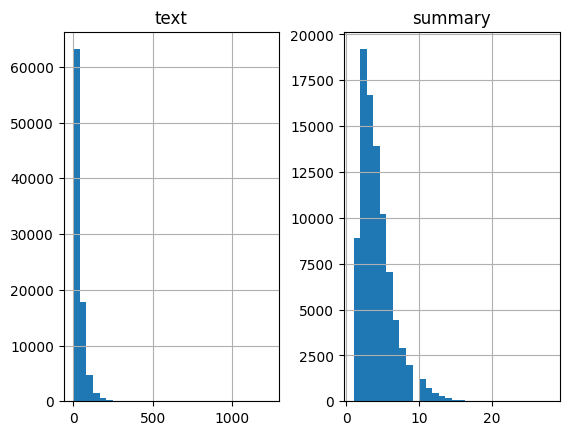

In [8]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data["cleaned_text"]:
    text_word_count.append(len(i.split()))

for i in data["cleaned_summary"]:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({"text": text_word_count, "summary": summary_word_count})

length_df.hist(bins=30)
plt.show()

### Only select reviews and summaries that follows some constraints

In [9]:
max_text_len = 30  # max text length
max_summary_len = 8  # max summary length

cleaned_text = np.array(data["cleaned_text"])
cleaned_summary = np.array(data["cleaned_summary"])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if (
        len(cleaned_summary[i].split()) <= max_summary_len
        and len(cleaned_text[i].split()) <= max_text_len
    ):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({"text": short_text, "summary": short_summary})

### Add START and END special tokens

In [10]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
print(df['summary'].head())

0                         sostok good quality dog food eostok
1                             sostok not as advertised eostok
2                                sostok cough medicine eostok
3                                   sostok great taffy eostok
4    sostok great just as good as the expensive brands eostok
Name: summary, dtype: object


### Split training and validation set

In [11]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df["text"]),
    np.array(df["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

## Tokenizers

### Text-tokenizer

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

### Rarewords

In [13]:
thresh = 4 # threshold for rare words

cnt = 0 # number of rare words
tot_cnt = 0 # size of the vocabulary
freq = 0    
tot_freq = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if value < thresh:
        cnt = cnt + 1
        freq = freq + value

print("% of rare words in vocabulary:", (cnt / tot_cnt) * 100)
print("Total Coverage of rare words:", (freq / tot_freq) * 100)

% of rare words in vocabulary: 66.07775273663876
Total Coverage of rare words: 2.94478384433473


In [14]:
# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

# convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen=max_text_len, padding="post")
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding="post")

# size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

print(x_voc)

8430


### Summary-tokenizer

In [15]:
# prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 6

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if value < thresh:
        cnt = cnt + 1
        freq = freq + value

print("% of rare words in vocabulary:", (cnt / tot_cnt) * 100)
print("Total Coverage of rare words:", (freq / tot_freq) * 100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print(y_voc)

% of rare words in vocabulary: 78.2646994054173
Total Coverage of rare words: 5.414143049204358
1975


In [16]:
# Delete rows that contain only START and END tokens

ind = []
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

## Model

In [ ]:
from keras import backend as K

K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# encoder lstm 1
encoder_lstm1 = LSTM(
    latent_dim,
    return_sequences=True,
    return_state=True,
    dropout=0.4,
    recurrent_dropout=0.4,
)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder lstm 2
encoder_lstm2 = LSTM(
    latent_dim,
    return_sequences=True,
    return_state=True,
    dropout=0.4,
    recurrent_dropout=0.4,
)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder lstm 3
encoder_lstm3 = LSTM(
    latent_dim,
    return_state=True,
    return_sequences=True,
    dropout=0.4,
    recurrent_dropout=0.4,
)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(
    latent_dim,
    return_sequences=True,
    return_state=True,
    dropout=0.4,
    recurrent_dropout=0.2,
)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(
    dec_emb, initial_state=[state_h, state_c]
)

# Attention layer
attn_layer = AttentionLayer(name="attention_layer")
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name="concat_layer")(
    [decoder_outputs, attn_out]
)

# dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation="softmax"))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")  


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 100)   │    843,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 30, 300), │    481,200 │ embedding[0][0]   │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm[0][0]        │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │    197,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm_1[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    481,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │    180,300 │ lstm_2[0][0],     │
│ (AttentionLayer)    │ 300), (None,      │            │ lstm_3[0][0]      │
│                     │ None, 30)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 600) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  1,186,975 │ concat_layer[0][… │
│ (TimeDistributed)   │ 1975)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,812,575 (18.36 MB)

 Trainable params: 4,812,575 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [20]:
es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=2
)  # early stopping

history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=(
        [x_val, y_val[:, :-1]],
        y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:],
    ),
)  # training

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 3.3860 - val_loss: 2.7053
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 2.7066 - val_loss: 2.5941
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 2.6027 - val_loss: 2.5424
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 2.5461 - val_loss: 2.4746
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 2.4925 - val_loss: 2.4136
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 2.4010 - val_loss: 2.3735
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 2.3553 - val_loss: 2.3100
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 2.3034 - val_loss: 2.2761
Epoch 9/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 2.2624 - val_loss: 2.2433
Epoch 10/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 2.2137 - val_loss: 2.2210
Epoch 11/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 2.1798 - val_loss: 2.1937
Epoch 12/50
323/323 ━━━━━━━━━━

## Plot

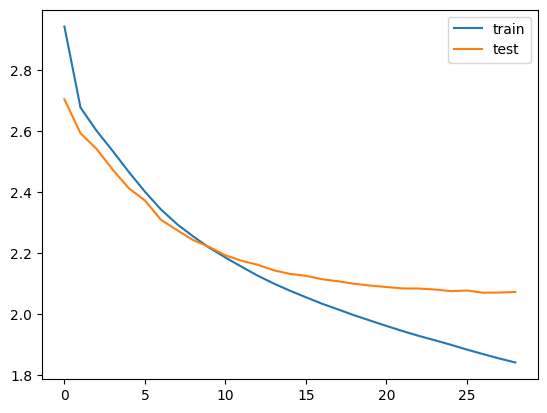

In [21]:
from matplotlib import pyplot

pyplot.plot(history.history["loss"], label="train")
pyplot.plot(history.history["val_loss"], label="test")
pyplot.legend()
pyplot.show()

## Inference

In [22]:
# Build the dictionary to convert the index to word for target and source vocabulary
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(
    inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c]
)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# attention inference
attn_out_inf, attn_states_inf = attn_layer(
    [decoder_hidden_state_input, decoder_outputs2]
)
decoder_inf_concat = Concatenate(axis=-1, name="concat")(
    [decoder_outputs2, attn_out_inf]
)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs]
    + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2],
)


# Inference function
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index["sostok"]

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != "eostok":
            decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop word.
        if sampled_token == "eostok" or len(decoded_sentence.split()) >= (
            max_summary_len - 1
        ):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


def seq2summary(input_seq):
    newString = ""
    for i in input_seq:
        if (i != 0 and i != target_word_index["sostok"]) and i != target_word_index[
            "eostok"
        ]:
            newString = newString + reverse_target_word_index[i] + " "
    return newString


def seq2text(input_seq):
    newString = ""
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + " "
    return newString

In [25]:
for i in range(0, 100):
    print("Review:", seq2text(x_tr[i]))
    print("Original summary:", seq2summary(y_tr[i]))
    print("Predicted summary:", decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print("\n")

Review: daughter used quaker instant oatmeal liked lot long time ago tried version like fact want finish sure maybe lots new ingredients artificial 
Original summary: not very good 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted summary:  not as good as


Review: liked coffee much subscribing dark rich smooth 
Original summary: makes great cup of java 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted summary:  great coffee


Review: like fool ordered box instead bag try disgusting smell like dead fish rinsed rinsed still smelled right light even look purple crack cannot believe stupid buy 
Original summary: gross 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/s